# Dependencias

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from varclushi import VarClusHi
from scipy import stats

import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta = 'Food Prices.csv'
df = pd.read_csv(ruta)
df.head()

,Country,Year,Month,Food Item,Unit of Measurement,Average Price,Currency,Price in USD,Availability,Quality
0,Australia,2018,1,Bread,Loaf,2.20,AUD,1.47,1,High
1,Australia,2018,2,Bread,Loaf,2.20,AUD,1.48,1,High
2,Australia,2018,3,Bread,Loaf,2.20,AUD,1.48,1,High
3,Australia,2018,4,Bread,Loaf,2.21,AUD,1.48,1,High
4,Australia,2018,5,Bread,Loaf,2.21,AUD,1.48,1,High


In [3]:
df.shape

(1200, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              1200 non-null   object 
 1   Year                 1200 non-null   int64  
 2   Month                1200 non-null   int64  
 3   Food Item            1200 non-null   object 
 4   Unit of Measurement  1200 non-null   object 
 5   Average Price        1200 non-null   float64
 6   Currency             1200 non-null   object 
 7   Price in USD         1200 non-null   float64
 8   Availability         1200 non-null   int64  
 9   Quality              1200 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 93.9+ KB


# Definición de variables

In [5]:
df.insert(0,'id',df.index+1)

In [6]:
um = ['id']
vart = ['Quality ']
varc = [v for v in df.columns if df[v].dtype!='object' and v not in um and v not in vart]
vard = [v for v in df.columns if v not in um and v not in vart and v not in varc]

# Análisis exploratorio

## Balanceo de muestra

In [7]:
df[vart].value_counts()

Quality 
High        960
Medium      240
dtype: int64

In [8]:
X = pd.concat([d.sample(240) for _,d in df.groupby(vart[0])], ignore_index=True)

In [9]:
X[vart].value_counts()

Quality 
High        240
Medium      240
dtype: int64

## Variables discretas

In [10]:
for v in vard:
    for a,b in zip(list(X[v].unique()),range(1,len(list(X[v].unique()))+1)):
        X.loc[X[v] == a,v] = b
    X[v] = pd.to_numeric(X[v])

In [11]:
varc = varc + vard

## Varianza nula

In [12]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [13]:
fuera = [a for a,b in zip(varc,vt.get_support()) if not b]
fuera

['Availability ']

In [14]:
X.drop(fuera[0],axis=1,inplace=True)
varc = [v for v in varc if v not in fuera]

## Valores nulos

In [15]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
Country,0.0
Year,0.0
Month,0.0
Food Item,0.0
Unit of Measurement,0.0
Average Price,0.0
Currency,0.0
Price in USD,0.0


In [16]:
fuera = [v for v in nulos.index if nulos['count'][v]>0.5]
fuera

[]

## Multicolinealidad

In [17]:
vc = VarClusHi(X,feat_list=varc).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Country,0.936407,0.012396,0.064391
1,0,Currency,0.936407,0.012396,0.064391
2,0,Average Price,0.645925,0.012337,0.358497
3,0,Month,0.019391,0.003462,0.984016
4,1,Unit of Measurement,0.932715,0.000142,0.067294
5,1,Food Item,0.924725,0.000127,0.075285
6,1,Price in USD,0.441164,0.145206,0.653767
7,2,Year,1.000000,0.002496,0.000000


['Country ', 'Unit of Measurement', 'Year ']

## Selección de variables con mejor poder predictivo

In [18]:
sk = SelectKBest(k = len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=8)

In [19]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [20]:
sk = SelectKBest(k = 3)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=3)

In [21]:
best = [a for a,b in zip(varc,sk.get_support()) if b]
best

['Price in USD', 'Country ', 'Currency ']

## Valores extremos

array([[<AxesSubplot:title={'center':'Price in USD'}>,
        <AxesSubplot:title={'center':'Country '}>],
       [<AxesSubplot:title={'center':'Currency '}>, <AxesSubplot:>]],
      dtype=object)

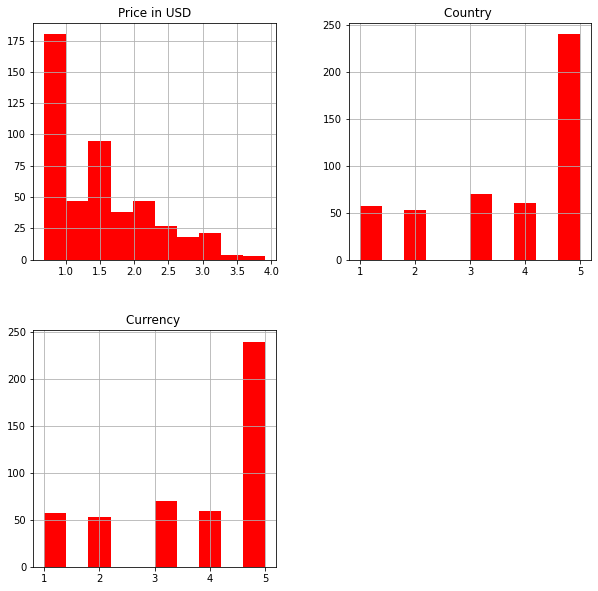

In [22]:
X[best].hist(figsize=(10,10),color='red')

In [23]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.98125
1    0.01875
Name: ex_, dtype: float64

In [24]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X.loc[X[v]<li,v]=np.nan
    X.loc[X[v]>ls,v]=np.nan

In [25]:
sm = SimpleImputer(strategy='median')
sm.fit(X[best])

SimpleImputer(strategy='median')

In [26]:
Xi = pd.DataFrame(sm.transform(X[best]),columns=best)
Xi[um+vart] = X[um+vart]

In [27]:
nulos = 1-Xi.describe().T[['count']]/len(Xi)
nulos

,count
Price in USD,0.0
Country,0.0
Currency,0.0
id,0.0


In [28]:
ks = pd.DataFrame(map(lambda v: (v,stats.ks_2samp(X[v].dropna(),Xi[v]).statistic), best),columns=['var','ks']).set_index('var')
ks.sort_values(by='ks', ascending=False, inplace=True)
ks

,ks
var,
Price in USD,0.009196
Country,0.000000
Currency,0.000000


In [29]:
fuera = [v for v in ks.index if ks['ks'][v]>0.05]
fuera

[]

array([[<AxesSubplot:title={'center':'Price in USD'}>,
        <AxesSubplot:title={'center':'Country '}>],
       [<AxesSubplot:title={'center':'Currency '}>, <AxesSubplot:>]],
      dtype=object)

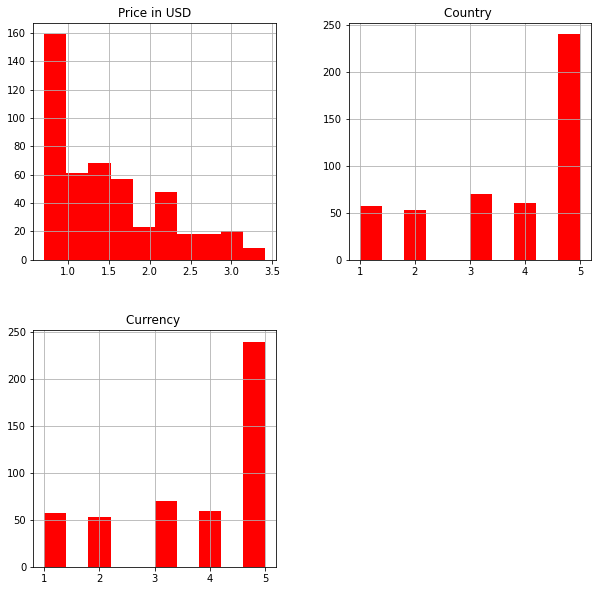

In [30]:
Xi[best].hist(figsize=(10,10),color='red')

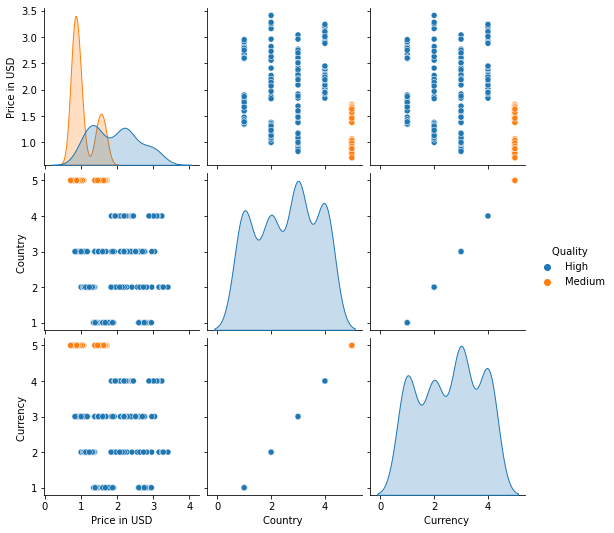

In [31]:
sns.pairplot(data=Xi[best+vart],hue=vart[0])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [32]:
sc = MinMaxScaler()
sc.fit(Xi[best])

MinMaxScaler()

In [33]:
X01 = pd.DataFrame(sc.transform(Xi[best]),columns=best)
X01[um+vart] = Xi[um+vart]

# Partición de entrenamiento

In [34]:
Xt, Xv = train_test_split(X01[um+best+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)

# Aprendizaje

## Perceptrón

In [35]:
hp = dict(max_iter=range(100,200),
         fit_intercept=[True,False])

modelo = Perceptron()

grid = GridSearchCV(param_grid=hp,
                   cv = 3,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [36]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3, estimator=Perceptron(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': range(100, 200)},
             scoring='accuracy', verbose=True)

In [37]:
grid.best_params_

{'fit_intercept': True, 'max_iter': 100}

In [38]:
modelo = grid.best_estimator_
modelo

Perceptron(max_iter=100)

In [39]:
modelo.fit(Xt[best],Xt[vart[0]])

Perceptron(max_iter=100)

### Validación del modelo

In [40]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

In [41]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [42]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


## Pasivo-Agresivo

In [43]:
hp = dict(max_iter=range(100,150),
         fit_intercept=[True,False],
         C = np.arange(0.1,1,0.1))

modelo = PassiveAggressiveClassifier()

grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [44]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 2 folds for each of 900 candidates, totalling 1800 fits


GridSearchCV(cv=2, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(100, 150)},
             scoring='accuracy', verbose=True)

In [45]:
grid.best_params_

{'C': 0.1, 'fit_intercept': True, 'max_iter': 100}

In [46]:
modelo = grid.best_estimator_
modelo

PassiveAggressiveClassifier(C=0.1, max_iter=100)

In [47]:
modelo.fit(Xt[best],Xt[vart[0]])

PassiveAggressiveClassifier(C=0.1, max_iter=100)

### Validación del modelo

In [48]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

In [49]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [50]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


## Análsis Discriminante

In [51]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[best],Xt[vart[0]])

LinearDiscriminantAnalysis()

### Validación del modelo

In [52]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

Xt['proba'] = modelo.predict_proba(Xt[best])[:,1]
Xv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [53]:
print(accuracy_score(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(accuracy_score(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

0.9940476190476191
1.0


In [54]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[169   2]
 [  0 165]]
[[69  0]
 [ 0 75]]


In [55]:
print(roc_auc_score(y_true=Xt[vart[0]],y_score=Xt['proba']))
print(roc_auc_score(y_true=Xv[vart[0]],y_score=Xv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

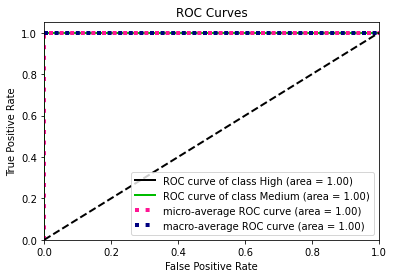

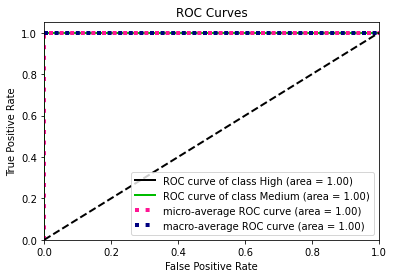

In [56]:
plot_roc(y_true=Xt[vart[0]],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Xv[vart[0]],y_probas=modelo.predict_proba(Xv[best]))

<AxesSubplot:xlabel='proba', ylabel='Density'>

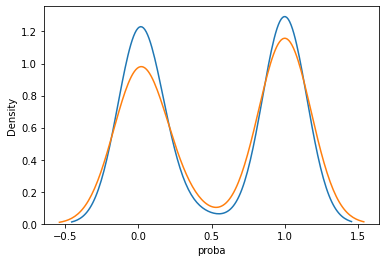

In [57]:
sns.kdeplot(Xt['proba'])
sns.kdeplot(Xv['proba'])

## SVM

In [58]:
hp = dict(C = np.arange(0.1,2,0.1),
         kernel=['linear','poly','rbf','sigmoid'],
         probability=[True],
         degree = range(2,3))

modelo = SVC()

grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [59]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 2 folds for each of 76 candidates, totalling 152 fits


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'degree': range(2, 3),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring='accuracy', verbose=True)

In [60]:
grid.best_params_

{'C': 0.1, 'degree': 2, 'kernel': 'linear', 'probability': True}

In [61]:
modelo = grid.best_estimator_
modelo

SVC(C=0.1, degree=2, kernel='linear', probability=True)

In [62]:
modelo.fit(Xt[best],Xt[vart[0]])

SVC(C=0.1, degree=2, kernel='linear', probability=True)

### Validación del modelo

In [63]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

Xt['proba'] = modelo.predict_proba(Xt[best])[:,1]
Xv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [64]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [65]:
print(confusion_matrix(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(confusion_matrix(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


In [66]:
print(roc_auc_score(y_true=Xt[vart[0]],y_score=Xt['proba']))
print(roc_auc_score(y_true=Xv[vart[0]],y_score=Xv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

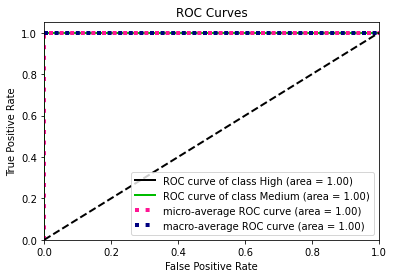

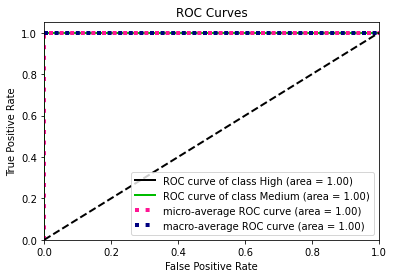

In [67]:
plot_roc(y_true=Xt[vart[0]],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Xv[vart[0]],y_probas=modelo.predict_proba(Xv[best]))

<AxesSubplot:xlabel='proba', ylabel='Density'>

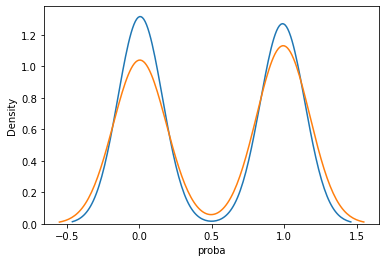

In [68]:
sns.kdeplot(Xt['proba'])
sns.kdeplot(Xv['proba'])

## LR

In [69]:
modelo = LogisticRegression(n_jobs=-1)
modelo.fit(Xt[best],Xt[vart[0]])

LogisticRegression(n_jobs=-1)

### Validación del modelo

In [70]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

Xt['proba'] = modelo.predict_proba(Xt[best])[:,1]
Xv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [71]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [72]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


In [73]:
print(roc_auc_score(y_true=Xt[vart[0]],y_score=Xt['proba']))
print(roc_auc_score(y_true=Xv[vart[0]],y_score=Xv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

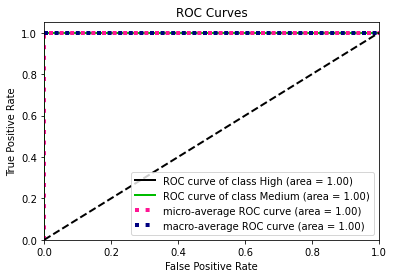

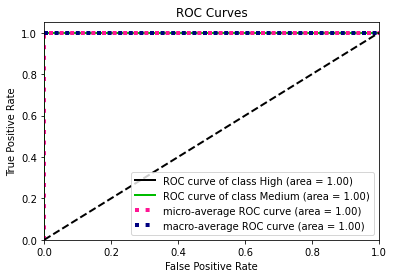

In [74]:
plot_roc(y_true=Xt[vart[0]],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Xv[vart[0]],y_probas=modelo.predict_proba(Xv[best]))

<AxesSubplot:xlabel='proba', ylabel='Density'>

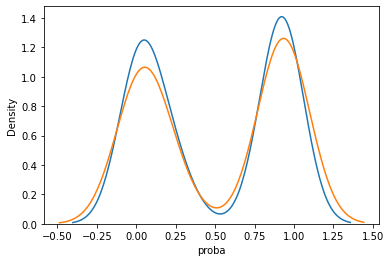

In [75]:
sns.kdeplot(Xt['proba'])
sns.kdeplot(Xv['proba'])

## Red Neuronal

In [76]:
hp = dict(hidden_layer_sizes = [(a,b,c) for a in range(2,3) for b in range(2,4) for c in range(2,3)],
         activation=['identity','logistic','tanh','relu'],
         solver=['sgd'],
         alpha=np.arange(0.0001,0.001,0.0001),
         learning_rate=['constant','invscaling','adaptive'],
         max_iter=[2500])

modelo = MLPClassifier()

grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='roc_auc',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [77]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 2 folds for each of 216 candidates, totalling 432 fits


/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'hidden_layer_sizes': [(2, 2, 2), (2, 3, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [2500], 'solver': ['sgd']},
             scoring='roc_auc', verbose=True)

In [78]:
grid.best_params_

{'activation': 'identity',
 'alpha': 0.0001,
 'hidden_layer_sizes': (2, 2, 2),
 'learning_rate': 'constant',
 'max_iter': 2500,
 'solver': 'sgd'}

In [79]:
modelo = grid.best_estimator_
modelo

MLPClassifier(activation='identity', hidden_layer_sizes=(2, 2, 2),
              max_iter=2500, solver='sgd')

In [80]:
modelo.fit(Xt[best],Xt[vart[0]])

MLPClassifier(activation='identity', hidden_layer_sizes=(2, 2, 2),
              max_iter=2500, solver='sgd')

### Validación del modelo

In [81]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

Xt['proba'] = modelo.predict_proba(Xt[best])[:,1]
Xv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [82]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [83]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


In [84]:
print(roc_auc_score(y_true=Xt[vart[0]],y_score=Xt['proba']))
print(roc_auc_score(y_true=Xv[vart[0]],y_score=Xv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

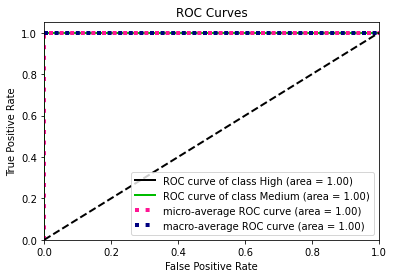

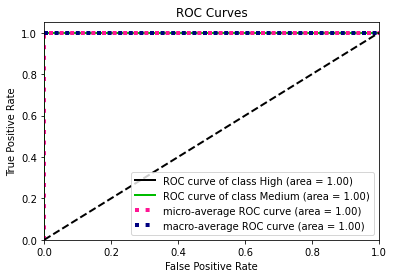

In [85]:
plot_roc(y_true=Xt[vart[0]],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Xv[vart[0]],y_probas=modelo.predict_proba(Xv[best]))

<AxesSubplot:xlabel='proba', ylabel='Density'>

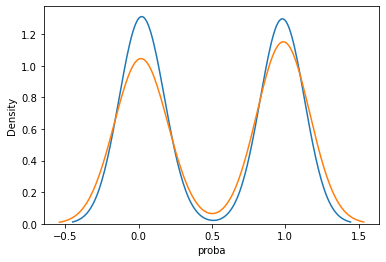

In [86]:
sns.kdeplot(Xt['proba'])
sns.kdeplot(Xv['proba'])

## Árbol de Decisión 

In [90]:
hp = dict(criterion = ['gini','entropy','log_loss'],
         splitter = ['best','random'],
         max_depth = range(1,10),
         min_samples_leaf = range(1,30,5))

modelo = DecisionTreeClassifier()

grid = GridSearchCV(param_grid=hp,
                   cv=3,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [91]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 30, 5),
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=True)

In [92]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'splitter': 'best'}

In [93]:
modelo = grid.best_estimator_
modelo

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'Country  <= 0.875\ngini = 0.5\nsamples = 336\nvalue = [171, 165]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 171\nvalue = [171, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 165\nvalue = [0, 165]')]

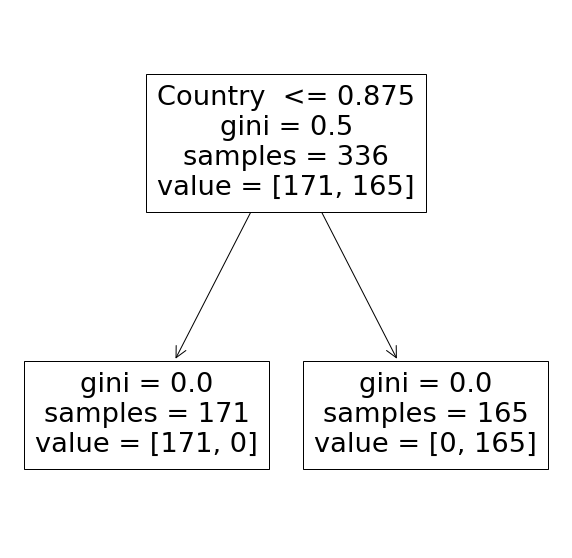

In [99]:
plt.figure(figsize=(10,10))
plot_tree(modelo,feature_names=best)

### Validación del modelo

In [100]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

Xt['proba'] = modelo.predict_proba(Xt[best])[:,1]
Xv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [102]:
print(accuracy_score(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(accuracy_score(y_true=Xv[vart[0]],y_pred=Xv['y^']))

1.0
1.0


In [103]:
print(confusion_matrix(y_true=Xt[vart[0]],y_pred=Xt['y^']))
print(confusion_matrix(y_true=Xv[vart[0]],y_pred=Xv['y^']))

[[171   0]
 [  0 165]]
[[69  0]
 [ 0 75]]


In [107]:
print(roc_auc_score(y_true=Xt[vart[0]],y_score=Xt['proba']))
print(roc_auc_score(y_true=Xv[vart[0]],y_score=Xv['proba']))

1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

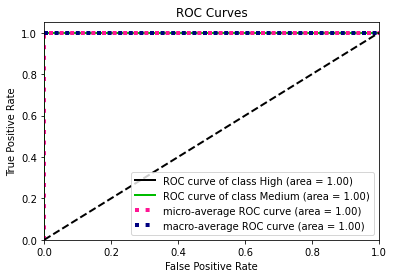

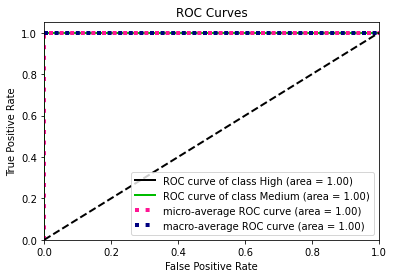

In [109]:
plot_roc(y_true=Xt[vart[0]],y_probas=modelo.predict_proba(Xt[best]))
plot_roc(y_true=Xv[vart[0]],y_probas=modelo.predict_proba(Xv[best]))

<AxesSubplot:xlabel='proba', ylabel='Density'>

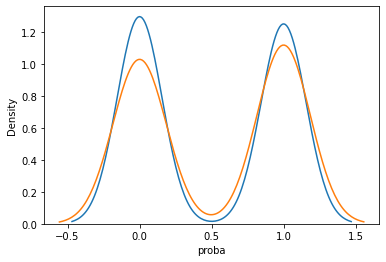

In [110]:
sns.kdeplot(Xt['proba'])
sns.kdeplot(Xv['proba'])